# Attention on MNIST

Lets build the mnist model and train it for 5 epochs. It should get to about ~99% test accuracy.

In [10]:
from __future__ import print_function

import numpy as np
import keras

from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Input
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 5

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 6s - loss: 0.2484 - acc: 0.9251 - val_loss: 0.0556 - val_acc: 0.9822
Epoch 2/5
60000/60000 [==============================] - 5s - loss: 0.0816 - acc: 0.9756 - val_loss: 0.0408 - val_acc: 0.9864
Epoch 3/5
60000/60000 [==============================] - 5s - loss: 0.0659 - acc: 0.9799 - val_loss: 0.0326 - val_acc: 0.9893
Epoch 4/5
60000/60000 [==============================] - 5s - loss: 0.0518 - acc: 0.9840 - val_loss: 0.0297 - val_acc: 0.9902
Epoch 5/5
60000/60000 [==============================] - 5s - loss: 0.0430 - acc: 0.9867 - val_loss: 0.0292 - val_acc: 0.9911
Test loss: 0.0292400684783
Test accuracy: 0.9911


## Saliency

To visualize attention over final dense layer outputs, we need to switch the `softmax` activation out for `linear` since gradient of output node `i` will depend on all the other node activations. In this case, I have simplified the example by using a `Dense` node with `linear` followed by `Activation('softmax')` so there is no need to do this swapping. Keep in mind that if swapping is not done, the results might be suboptimal. Reasons for this is mentioned in the documentation.

Lets pick an input over which we want to show the attention.

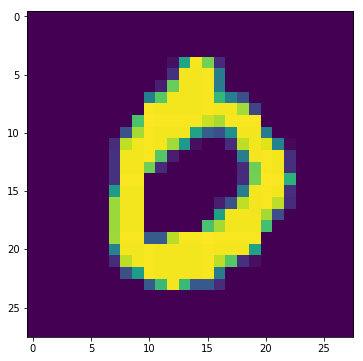

In [11]:
class_idx = 0
indices = np.where(y_test[:, class_idx] == 1.)[0]

# pick some random input from here.
idx = indices[0]

# Lets sanity check the picked image.
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

plt.imshow(x_test[idx][..., 0])

Time for saliency visualization.

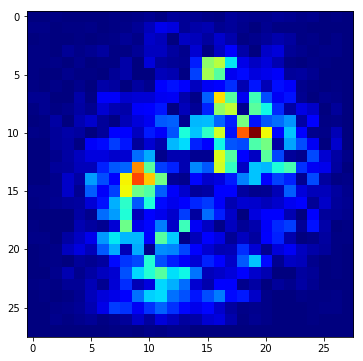

In [12]:
from vis.visualization import visualize_class_saliency

# This corresponds to the Dense linear layer.
layer_idx = -2
heatmap = visualize_class_saliency(model, layer_idx, filter_indices=class_idx, seed_input=x_test[idx])
plt.imshow(heatmap)

Looks ok. Lets try all the classes and show original inputs and their heatmaps side by side. We cannot overlay the heatmap on original image since its grayscale.

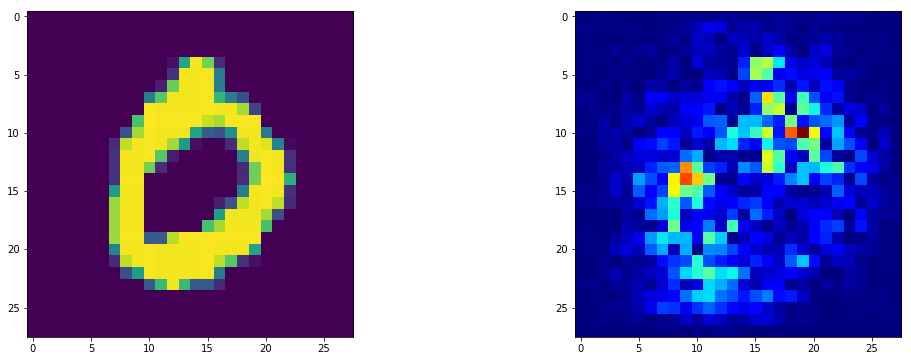

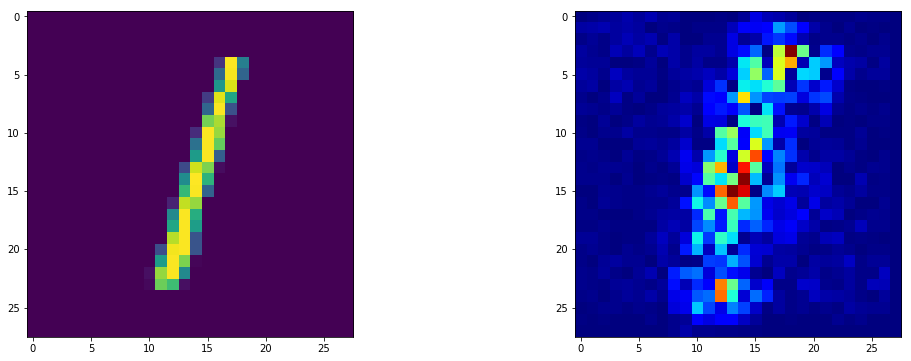

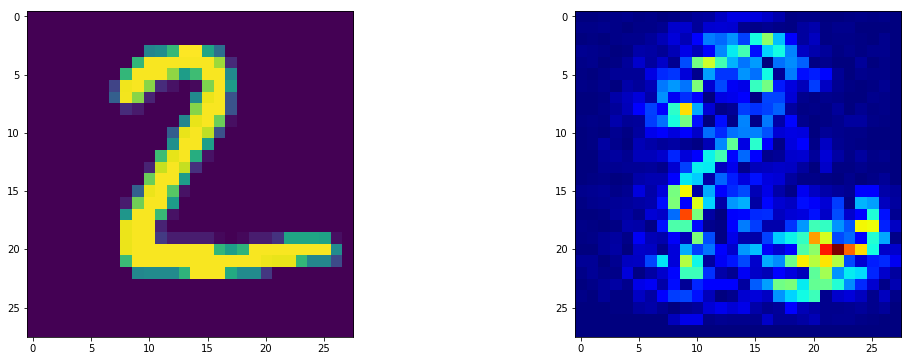

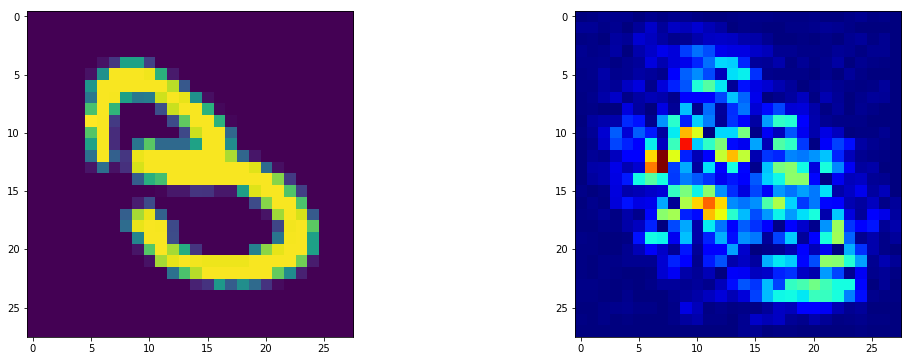

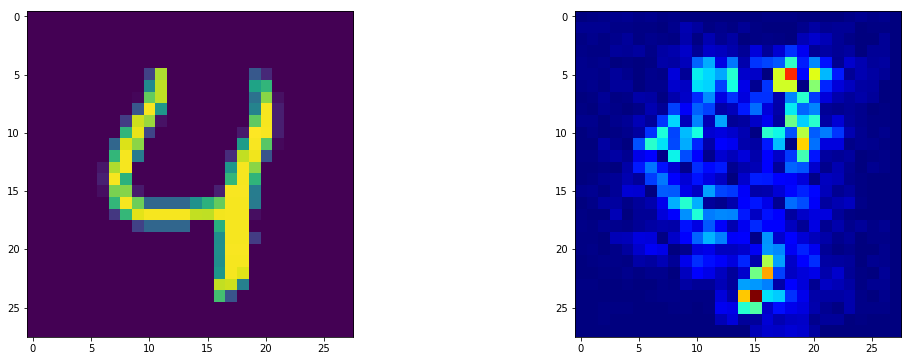

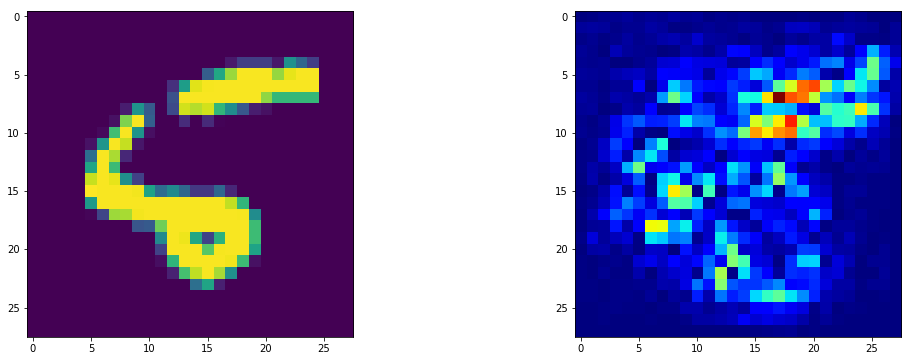

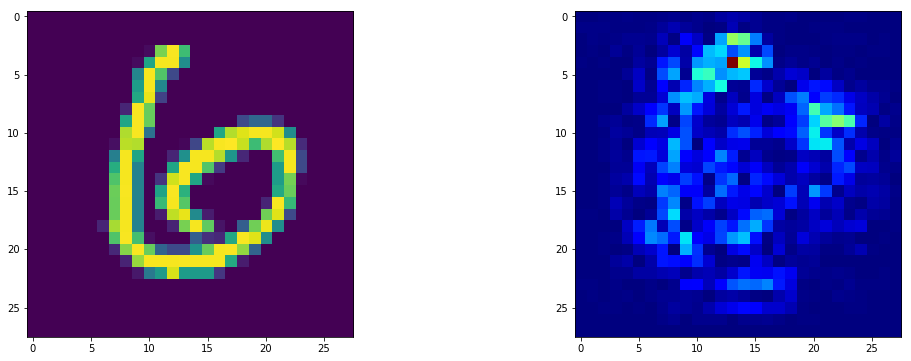

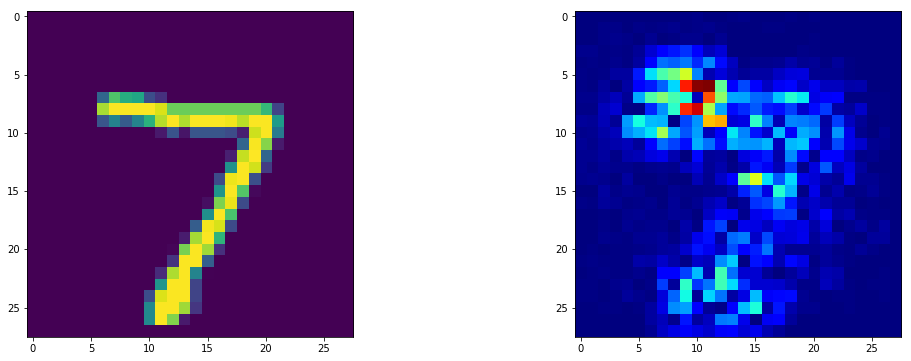

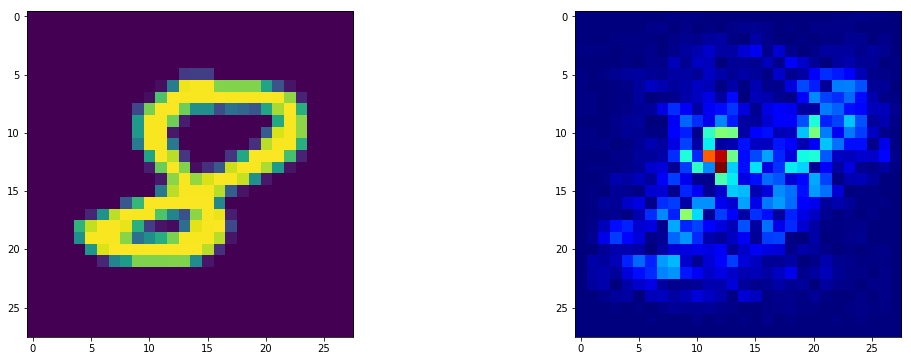

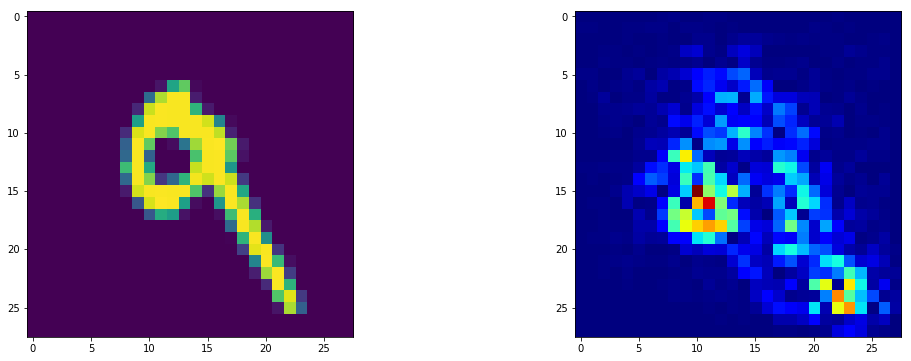

In [13]:
# This corresponds to the Dense linear layer.
for class_idx in np.arange(10):    
    indices = np.where(y_test[:, class_idx] == 1.)[0]
    idx = indices[0]
    heatmap = visualize_class_saliency(model, layer_idx, filter_indices=class_idx, seed_input=x_test[idx])

    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(x_test[idx][..., 0])
    ax2.imshow(heatmap)

Cool! That looks accurate.

## grad-CAM

These should contain more detail since they use `Conv` or `Pooling` features that contain more spatial detail which is lost in `Dense` layers. The only additional detail compared to saliency is the `penultimate_layer_idx`. This specifies the pre-layer whose gradients should be used. See this paper for technical details: https://arxiv.org/pdf/1610.02391v1.pdf

By default, if `penultimate_layer_idx` is not defined, it searches for the nearest pre layer. For our architecture, that would be the `MaxPooling2D` layer after all the `Conv` layers.

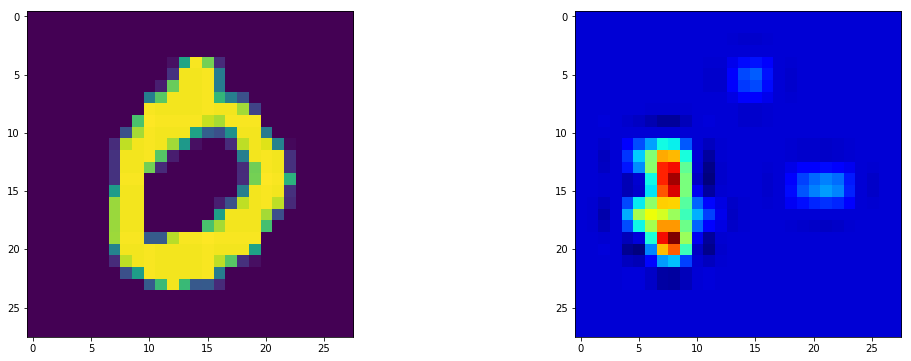

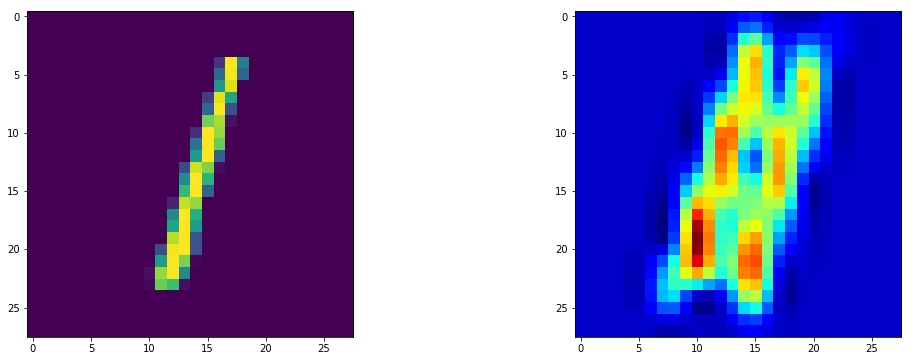

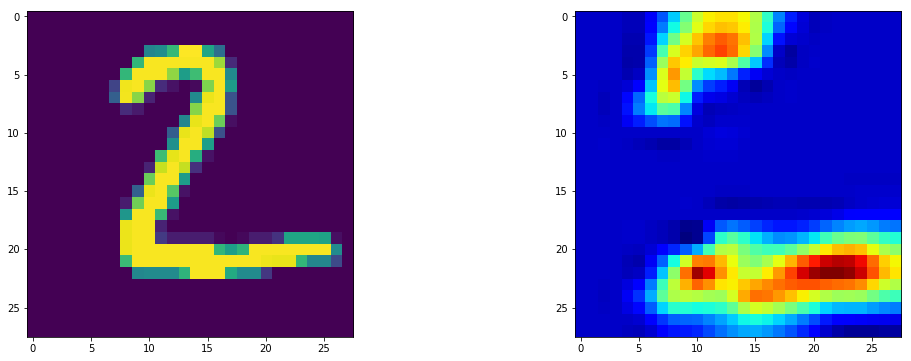

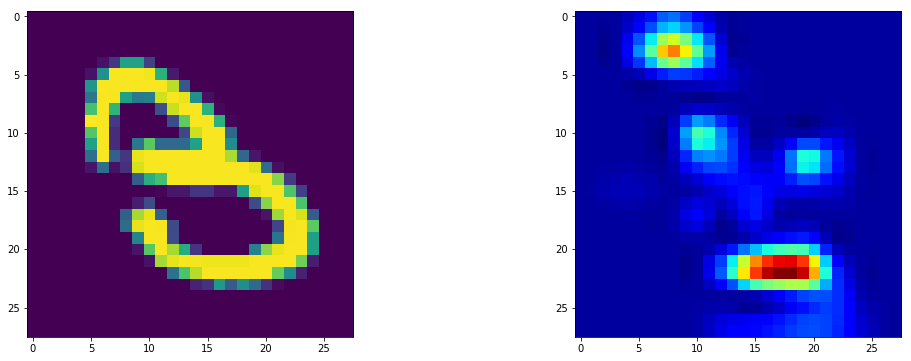

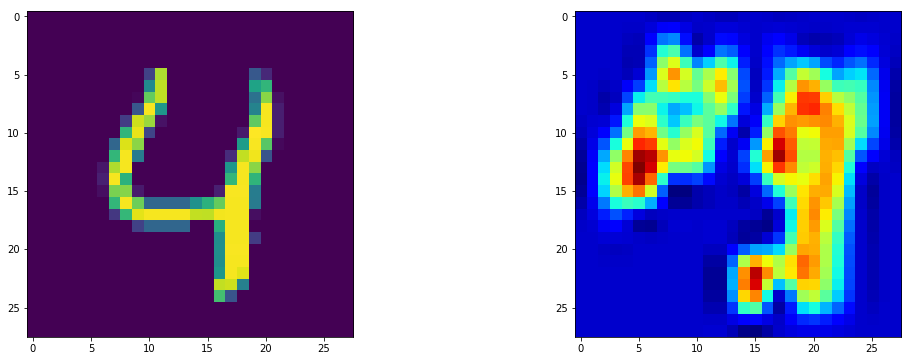

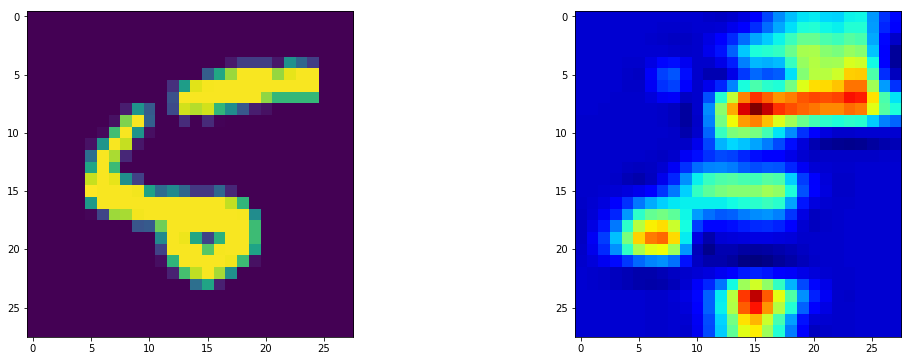

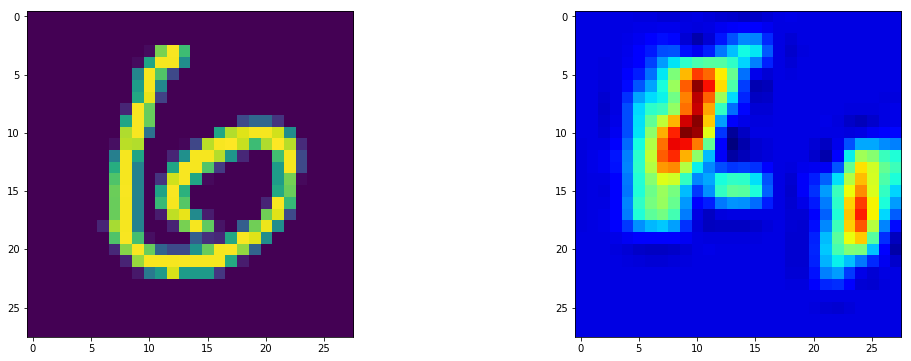

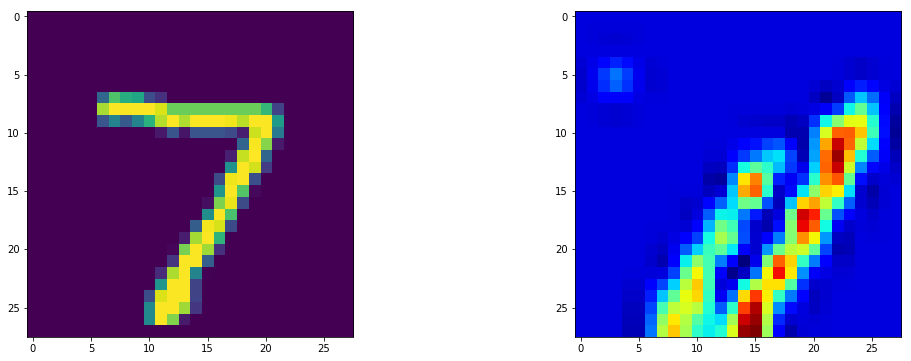

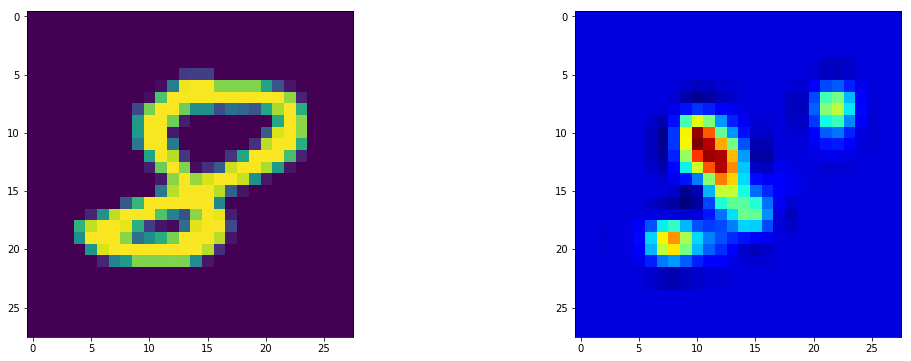

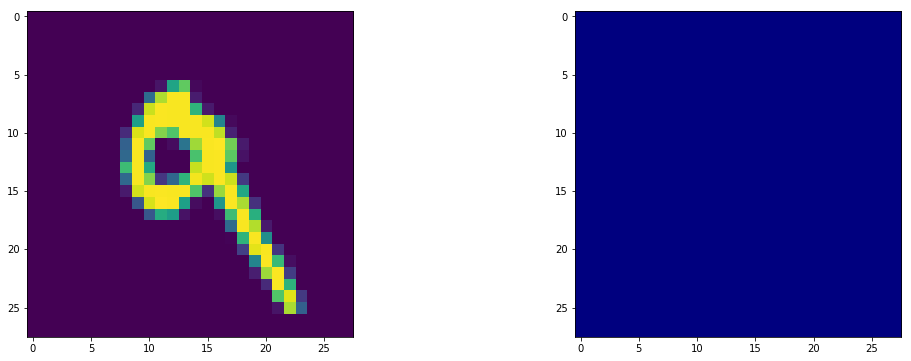

In [14]:
from vis.visualization import visualize_class_cam

# This corresponds to the Dense linear layer.
for class_idx in np.arange(10):    
    indices = np.where(y_test[:, class_idx] == 1.)[0]
    idx = indices[0]
    heatmap = visualize_class_cam(model, layer_idx, filter_indices=class_idx, seed_input=x_test[idx])

    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(x_test[idx][..., 0])
    ax2.imshow(heatmap)

In this case it appears that saliency is better than grad-CAM as penultimate `MaxPooling2D` layer has `(12, 12)` spatial resolution which is relatively large as compared to input of `(28, 28)`. Is is likely that the conv layer hasnt captured enough high level information and most of that is likely within `dense_4` layer. 

Here is the model summary for reference.

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
__________